# Implenent Q-Network for Deep Q-Learning (30 points)

In [1]:
import functools, itertools, collections, re, os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import gym

import torch
import torch.nn as nn

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

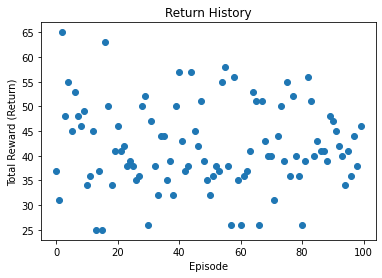

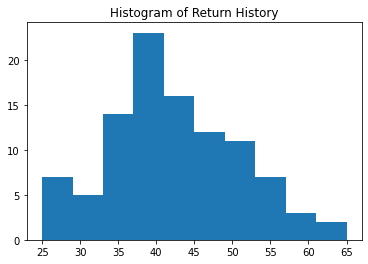

mean=41.90, std=8.52, min=25.00, max=65.00


In [2]:
def evaluate_policy(get_action, num_episodes=10, render=False):
  return_history = []
  max_steps_per_episode = 200
  for i_episode in range(num_episodes):
    state = env.reset()
    if render:
      env.render()
    total_reward = 0
    for t in range(max_steps_per_episode):
      action = get_action(state)
      state, reward, done, info = env.step(action)
      total_reward += reward
      if done:
  #       print(f'{i_episode + 1}: total_reward={total_reward}')
        break
    return_history.append(total_reward)
  if render:
    env.close()
  plt.plot(return_history, 'o')
  plt.title('Return History')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (Return)')
  plt.show()

  plt.hist(return_history)
  plt.title('Histogram of Return History')
  plt.show()
  print(f'mean={np.mean(return_history):.2f}, std={np.std(return_history):.2f}, min={np.min(return_history):.2f}, max={np.max(return_history):.2f}')
  return return_history

def random_policy(state):
  return env.action_space.sample()

def heuristic_policy(state):
  angle = state[2]
  if angle < 0:
    return 0
  return 1

env = gym.make('CartPole-v0')
return_history = evaluate_policy(heuristic_policy, 100)

## The Q-value function $Q(s, a)$ measures how good a (state, action) pair is. It is unknown to us.
## We can use deep-Q learning to learn the Q-value function.
## Define a two-layer neural network as Q-value function.
## We then build an agent with this Q-value function as its policy network, and update it with deep-Q learning.
## With learned Q value function, we can get the optimal policy:
$$
\pi(a|s) = \underset{a}{\operatorname{argmax}} Q(s, a)
$$

In [15]:
class QNet(nn.Module):
  def __init__(self, num_hidden_units=1024, num_actions=2, num_states=4):
    super().__init__()
    ###########################################Start your code here#######################################################
    # Define the following three layers (15 points):
    # A linear layer with in_features=4, out_features=1024; other arguments are default values
    # A ReLU activation layer
    # A linear layer with in_features=1024, out_features=2; other arguments are default values
    self.fc=nn.Linear(in_features=4, out_features=1024)
    self.relu = nn.ReLU()
    self.fc2=nn.Linear(in_features=1024, out_features=2)



    ###########################################End your code##############################################################
    
  def forward(self, state):
    # State is a torch.Tensor with shape (batch_size, num_states)
    # Return a tensor with shape (batch_size, num_actions)
    ###########################################Start your code here#######################################################
    # Finish the forward function (15 points)
    x1=self.fc(state)
    r1=self.relu(x1)
    result = self.fc2(r1)

    #print(result.size())
    
    return result


    ###########################################End your code##############################################################

### Suppose the agent has a limited (replay) memory. 
### We design a class with a memory represented as a list to support fast appending a new item and randomly sampling a batch of items from the memory. 
### When the memory is full, placing a new item at the position of the oldest item in the memory (therefore removing the old item). 

In [16]:
class ReplayMemory:
  def __init__(self, memory_size, initial_value=None):
    self.memory_size = memory_size
    self.memory = [initial_value] * self.memory_size
    self.index = 0
    
  def append(self, item):
    self.memory[self.index] = item
    self.index = (self.index + 1) % self.memory_size
    
  def sample(self, n):
    return random.sample(self.memory, n)

In [17]:
class Agent:
  def __init__(self, exploration_rate=0.01, gamma=0.9, memory_size=500, num_hidden_units=1024, num_actions=2, num_states=4):
    self.policy = QNet(num_hidden_units, num_actions, num_states)
    self.memory = ReplayMemory(memory_size)
    self.exploration_rate = exploration_rate
    self.gamma = gamma
    self.num_actions = num_actions
    self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.policy.parameters()), lr=5e-3, weight_decay=1e-5)
    
  def act(self, state, exploration_rate=None):
    if exploration_rate is None:
      exploration_rate = self.exploration_rate
    if np.random.rand() < exploration_rate:
      # exploration
      action = random.sample(range(self.num_actions), 1)[0]
    else:
      # exploitation
      state = torch.from_numpy(state).unsqueeze(0).float()
      action_logits = self.policy(state)
      action = torch.argmax(action_logits).item()
    return action
    
  def recall(self, batch_size):
    batch = random.sample(self.memory.memory, batch_size)
    state, action, reward, next_state, done = list(zip(*batch))
    state = torch.from_numpy(np.array(state)).float()
    action = torch.Tensor(action).long()
    reward = torch.Tensor(reward).float()
    next_state = torch.from_numpy(np.array(next_state)).float()
    done = torch.Tensor(done).float()
    return state, action, reward, next_state, done
  
  def update_policy(self, batch_size, optimizer=None, loss_fn=nn.SmoothL1Loss()):
    if optimizer is None:
      optimizer = self.optimizer
    state, action, reward, next_state, done = self.recall(batch_size)
    action_logits = self.policy(state)                          # return a tensor with shape (batch_size, num_actions)
    current_q_estimate = action_logits[range(batch_size), action]      # return a tensor with shape (batch_size, )
    new_q_estimate = reward + (1 - done) * self.gamma * self.policy(next_state).max(dim=1)[0]
    loss = loss_fn(current_q_estimate, new_q_estimate)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [18]:
env = gym.make('CartPole-v0')
agent = Agent()
max_num_episodes = 2000
max_steps_per_episode = 200
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_rate_decay_step_size = (max_exploration_rate - min_exploration_rate) / 100
batch_size = 50
return_history = []
loss_history = []
exploration_rate = max_exploration_rate
with tqdm.trange(max_num_episodes) as t:
  for i_episode in t:
    total_reward = 0
    if exploration_rate > min_exploration_rate:
      exploration_rate -= exploration_rate_decay_step_size
    state = env.reset().astype(np.float32)
    for _ in range(max_steps_per_episode):
      action = agent.act(state, exploration_rate=exploration_rate)
      next_state, reward, done, info = env.step(action)
      agent.memory.append((state, action, reward, next_state, done))
      state = next_state.astype(np.float32)
      total_reward += reward
      if done:
        break
    if i_episode >= 200:
      loss = agent.update_policy(batch_size)
      loss_history.append(loss)
    return_history.append(total_reward)
    mean_return = np.mean(return_history[-100:])
    if mean_return > 195:
      print('********************************Solved*****************************')
      print(f'{i_episode+1}: {mean_return}')
      break
    t.set_description(f'Episode {i_episode + 1}')
    t.set_postfix(mean_return=mean_return)

Episode 779:  39%|███▉      | 779/2000 [00:22<00:35, 34.52it/s, mean_return=195]

********************************Solved*****************************
780: 195.12


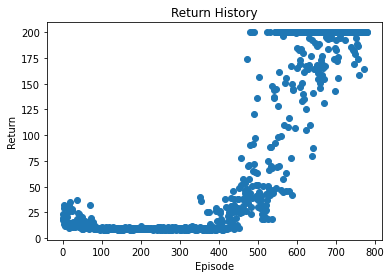

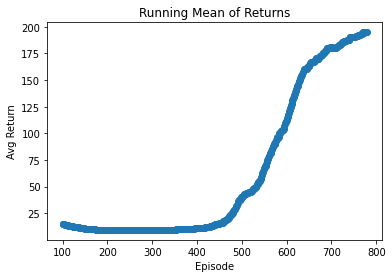

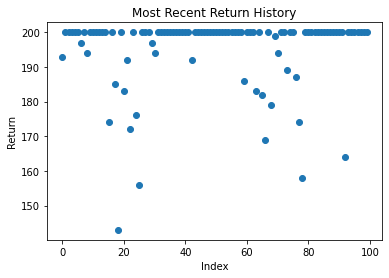

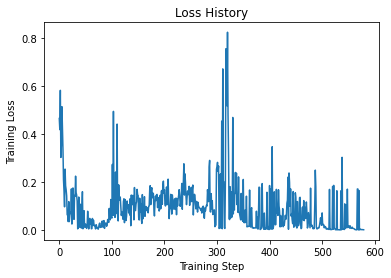

In [19]:
plt.plot(return_history, 'o')
plt.title('Return History')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()
plt.scatter(range(100, len(return_history)), [np.mean(return_history[i-100:i]) for i in range(100, len(return_history))])
plt.title('Running Mean of Returns')
plt.xlabel('Episode')
plt.ylabel('Avg Return')
plt.show()
plt.plot(return_history[-100:], 'o')
plt.title('Most Recent Return History')
plt.xlabel('Index')
plt.ylabel('Return')
plt.show()
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.show()

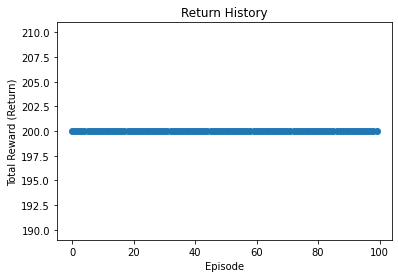

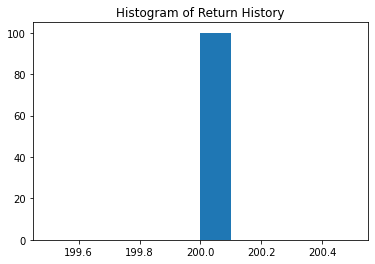

mean=200.00, std=0.00, min=200.00, max=200.00


In [ ]:
def get_action(state):
  return agent.act(state, exploration_rate=0)

return_history = evaluate_policy(get_action, num_episodes=100, render=False)